### Load Docs

In [ ]:
# mount google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load docs
import os

folder_path = 'put all your pdfs in a folder, and replace with the folder path.'
docs = os.listdir(folder_path)

print(f"Found {len(docs)} PDF files:")
for doc in docs:
    print(f"- {doc}")

Found 1 PDF files:
- Knowledge Graph Prompting for Multi-Document Question Answering.pdf


### KG Construction

In [ ]:
! pip install "camelot-py[cv]"
! pip install PyMuPDF
! pip install pdfplumber
! pip install together
! pip install PyPDF2
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalle

In [ ]:
import camelot
import fitz
import pdfplumber
import re
from together import Together
import json
import PyPDF2
import spacy
from bisect import bisect_right

def table_to_markdown(doc):

  doc_path = f'{folder_path}/{doc}'
  tables = camelot.read_pdf(doc_path, pages='all')
  markdown_table_list = []
  for i, table in enumerate(tables):
      markdown_table = table.df.to_markdown(index=False)
      page_number = table.page
      markdown_table_list.append((page_number, markdown_table))

  return markdown_table_list


def doc_to_passage(doc):
    doc_path = f'{folder_path}/{doc}'
    nlp = spacy.load("en_core_web_sm")
    passages_list = []

    with open(doc_path, 'rb') as doc_file:
        pdf_reader = PyPDF2.PdfReader(doc_file)
        texts_by_page = [page.extract_text() or "" for page in pdf_reader.pages]
        full_text = "".join(texts_by_page)
        page_offsets = [0]
        current_offset = 0
        for page_text in texts_by_page:
          current_offset += len(page_text)
          page_offsets.append(current_offset)

        document = nlp(full_text)
        for sent in document.sents:
            passage = sent.text.strip()
            if not passage:
                continue
            start_char = sent.start_char
            end_char = sent.end_char - 1
            start_page_idx = bisect_right(page_offsets, start_char) - 1
            end_page_idx = bisect_right(page_offsets, end_char) - 1
            start_page_num = start_page_idx + 1
            end_page_num = end_page_idx + 1
            if start_page_num == end_page_num:
              page_number_output = start_page_num
            else:
              page_number_output = (start_page_num, end_page_num)
            passages_list.append((page_number_output, passage))

    return passages_list

In [ ]:
# Embedding
!pip install -U sentence-transformers

import torch
from sentence_transformers import SentenceTransformer
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = SentenceTransformer('BAAI/bge-large-en-v1.5', device=device)


def get_bge_embeddings(texts: list[str]) -> np.ndarray:

    embeddings = embedding_model.encode(texts, convert_to_tensor=False, show_progress_bar=True)

    return embeddings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### Construct the KG

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle


def kg_construction(docs, similarity_threshold=0.75):

  G = nx.DiGraph()

  # for each pdf in docs
  for doc in docs:
        print(f"Processing document:\n {doc}")
        doc_path = f'{folder_path}/{doc}'

        document_title = doc.replace('.pdf', '').replace('_', ' ')

        tables_original = table_to_markdown(doc)
        passages_original = doc_to_passage(doc)

        passages = [
            (page_num, f"{document_title}. {passage_text}")
            for page_num, passage_text in passages_original
        ]
        tables = [
            (page_num, f"{document_title}.\n\n{table_data}")
            for page_num, table_data in tables_original
        ]

        passage_texts = []
        page_nodes = set()

        for i, (page_num, passage_text) in enumerate(passages):
            passage_id = f"{doc}_passage_{i}"
            page_id_str = f"{page_num[0]}-{page_num[1]}" if isinstance(page_num, tuple) else str(page_num)
            page_id = f"{doc}_page_{page_id_str}"

            G.add_node(passage_id, type='passage', content=passage_text)
            passage_texts.append(passage_text)

            if page_id not in page_nodes:
                G.add_node(page_id, type='page')
                page_nodes.add(page_id)
            G.add_edge(page_id, passage_id, type='structural')

        for i, (page_num, table_data) in enumerate(tables):
            table_id = f"{doc}_table_{i}"
            page_id = f"{doc}_page_{page_num}"
            G.add_node(table_id, type='table', content=table_data)
            if page_id not in page_nodes:
                G.add_node(page_id, type='page')
                page_nodes.add(page_id)
            G.add_edge(page_id, table_id, type='structural')

        if len(passage_texts) > 1:
            print(f"  Calculating embeddings for {len(passage_texts)} passages...")

            embeddings = get_bge_embeddings(passage_texts)

            for i, embedding in enumerate(embeddings):
                passage_id = f"{doc}_passage_{i}"
                G.nodes[passage_id]['vector'] = embedding

            print("  Calculating similarity matrix...")
            sim_matrix = cosine_similarity(embeddings)

            similar_indices = np.where(sim_matrix > similarity_threshold)

            for i, j in zip(*similar_indices):
                if i >= j:
                    continue

                passage_id_1 = f"{doc}_passage_{i}"
                passage_id_2 = f"{doc}_passage_{j}"

                G.add_edge(passage_id_1, passage_id_2, type='similarity', weight=sim_matrix[i, j])
                G.add_edge(passage_id_2, passage_id_1, type='similarity', weight=sim_matrix[i, j])
  print("Finished processing all documents.\n")

  # Save KG
  with open("graph.pkl", "wb") as f:
      pickle.dump(G, f)
  return G

### Visualize graph

In [ ]:
def visualize_graph(G):
    if not G.nodes:
        print("Graph is empty, nothing to visualize.")
        return

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=1.2, iterations=50, seed=42)
    custom_labels = {}
    for node_id in G.nodes():
        node_type = G.nodes[node_id].get('type', 'unknown')
        parts = node_id.split('_')
        number = parts[-1]

        if node_type == 'page':
            custom_labels[node_id] = number
        elif node_type == 'passage':
            custom_labels[node_id] = f"P{number}" # P for Passage
        elif node_type == 'table':
            custom_labels[node_id] = f"T{number}" # T for Table
        else:
            custom_labels[node_id] = node_id
    # -------------------------------------------

    node_colors = []
    node_shapes = []
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        if node_type == 'passage':
            node_colors.append('grey')
            node_shapes.append('o')
        elif node_type == 'page':
            node_colors.append('skyblue')
            node_shapes.append('^')
        elif node_type == 'table':
            node_colors.append('salmon')
            node_shapes.append('s')
        else:
            node_colors.append('black')
            node_shapes.append('d')

    edge_colors = [G.edges[u, v].get('type', 'unknown') for u, v in G.edges()]
    edge_color_map = {'structural': 'green', 'similarity': 'black', 'unknown': 'red'}
    final_edge_colors = [edge_color_map[etype] for etype in edge_colors]

    nx.draw_networkx_edges(G, pos, edge_color=final_edge_colors, alpha=0.6, arrows=True, arrowstyle='->', arrowsize=15)

    unique_shapes = set(node_shapes)
    for shape in unique_shapes:
        shape_nodes = [node for i, node in enumerate(G.nodes()) if node_shapes[i] == shape]
        shape_colors = [node_colors[i] for i, node in enumerate(G.nodes()) if node_shapes[i] == shape]

        nx.draw_networkx_nodes(G, pos, nodelist=shape_nodes,
                               node_shape=shape,
                               node_color=shape_colors,
                               node_size=2500,
                               alpha=0.9)

    nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=9, font_color='black', font_weight='bold')
    # ------------------------------------------------

    plt.title("Constructed Knowledge Graph", size=20)
    plt.box(False)
    plt.show()

### Traversal Agent

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from together import Together

client = Together(api_key='Fill with your api Key.')

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_seed(question: str, KG, embedding_model, top_k=1):

    question_with_instruction = f"Represent this sentence for searching relevant passages: {question}"
    question_embedding = embedding_model.encode(question_with_instruction)

    passage_embeddings = []
    passage_ids = []

    for node_id, data in KG.nodes(data=True):
        if data.get('type') == 'passage' and 'vector' in data:
            passage_ids.append(node_id)
            passage_embeddings.append(data['vector'])

    if not passage_ids:
        return []


    sim_scores = cosine_similarity(question_embedding.reshape(1, -1), np.array(passage_embeddings))[0]

    # ۴. top k indices
    top_indices = sim_scores.argsort()[::-1][:top_k]

    top_seeds = [passage_ids[i] for i in top_indices]

    print(f"Top {top_k} seed nodes found:")
    for i in top_indices:
        print(f"  - ID: {passage_ids[i]} (Similarity Score: {sim_scores[i]:.4f})")

    return top_seeds



def llm(prompt, stream=False, max_tokens=500, temperature=0.7, stop=None, display_stream=False):
    try:
        response = client.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
            prompt=prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            stream=stream,
            stop=stop
        )

        generated = ""
        if stream:
            for token in response:
                if hasattr(token, 'choices'):
                    chunk = token.choices[0].delta.content
                    if display_stream:
                      print(chunk, end='', flush=True)
                    generated += chunk
            return generated.strip()
        else:
            return response.choices[0].text.strip()

    except Exception as e:
        print("❌ LLaMA API Error:", e)
        return ""


def llm_generate_next_passage(user_question, retrieved_context, max_tokens=100):
    formatted_context = "\n".join([f"- {ctx.strip()}" for ctx in retrieved_context])

    prompt_prefix = """You are an agent that, given a question and the context gathered so far, generates the next piece of evidence—i.e. the sentence or fact you should retrieve next from the knowledge graph to eventually answer the question. Respond with exactly that next evidence as a single concise sentence.

    Format for each example:

    Question: <the user’s question>
    Context:
    - <retrieved passage 1>
    - <retrieved passage 2>
    …
    Next evidence: <model’s output>

    ––––––––––––––––––––––––––––––––––––––––––––––

    Example 1
    Question: Who composed the current arrangement of the Simpsons theme?
    Context:
    - “The Simpsons” is an American animated sitcom created by Matt Groening.
    - Alf Clausen (born March 28, 1941) is an American film composer.
    Next evidence: Alf Clausen became the primary composer for The Simpsons in 1989.

    Example 2
    Question: In what year did the composer of the Simpsons theme arrange the current version?
    Context:
    - Alf Clausen became the primary composer for The Simpsons in 1989.
    Next evidence: The current arrangement of the theme was first introduced in 1990.

    Example 3
    Question: Who directed the film in which the lead actor won an Oscar?
    Context:
    - "The King's Speech" is a film directed by Tom Hooper.
    - Colin Firth won the Academy Award for Best Actor for his role in that film.
    Next evidence: Tom Hooper won the Academy Award for Best Director in 2011.
    ––––––––––––––––––––––––––––––––––––––––––––––
    """

    full_prompt = f"""{prompt_prefix}

    Now apply to the user’s question:

    Question: {user_question}
    Context:
    {formatted_context}
    Next evidence:"""

    output = llm(full_prompt, stream=False, max_tokens=max_tokens)

    if output:
        processed_output = output.split('\n')[0].strip()
        return processed_output
    else:
        return ""


def graph_traversal(G, question, seed_nodes, llm_generate_next_passage, context_budget=5):

    visited = set()
    retrieved = []
    candidate_queue = list(seed_nodes)

    print("--- Starting Graph Traversal ---")
    print(f"Initial seeds: {seed_nodes}\n")

    step = 0
    while candidate_queue and len(retrieved) < context_budget:
        current_node = candidate_queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)

        retrieved.append(current_node)
        step += 1
        print(f"➡️ Step {step}: Visiting Node → {current_node}")
        print(f"   Content: \"{G.nodes[current_node]['content'][:100].strip()}...\"")

        if len(retrieved) >= context_budget:
            break

        # 2) gnerate next passage with LLM
        retrieved_texts = [G.nodes[n]['content'] for n in retrieved]

        print("\n   📜 Context prompt is being built with following passages:")
        for i, text in enumerate(retrieved_texts):
            print(f"      {i+1}. \"{text[:80].strip()}...\"")

        predicted_text = llm_generate_next_passage(question, retrieved_texts, max_tokens=100)
        print(f"   🤖 LLM-Generated Next Evidence: \"{predicted_text}\"")

        neighbors = list(G.neighbors(current_node))
        neighbor_ids, neighbor_contents = [], []
        for nbr in neighbors:
            if G.nodes[nbr].get('type') != 'passage' or nbr in visited:
                continue
            neighbor_ids.append(nbr)
            neighbor_contents.append(G.nodes[nbr]['content'])

        if not neighbor_ids:
            print("  ↳ No unvisited passage neighbors.")
            continue

        neighbor_embeddings = [G.nodes[nbr]['vector'] for nbr in neighbor_ids]
        predicted_embedding = get_bge_embeddings([predicted_text])[0]
        scores = cosine_similarity([predicted_embedding], neighbor_embeddings)[0]
        top_idx = scores.argmax()

        next_node = neighbor_ids[top_idx]
        print(f"  ↳ Adding to queue: {next_node} (score: {scores[top_idx]:.4f})")
        candidate_queue.append(next_node)

    print("\nTraversal complete. Retrieved nodes:", retrieved)
    return retrieved


### main

In [ ]:
KG = kg_construction(docs, similarity_threshold=0.86)


Processing document:
 Knowledge Graph Prompting for Multi-Document Question Answering.pdf
  Calculating embeddings for 337 passages...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

  Calculating similarity matrix...
Finished processing all documents.



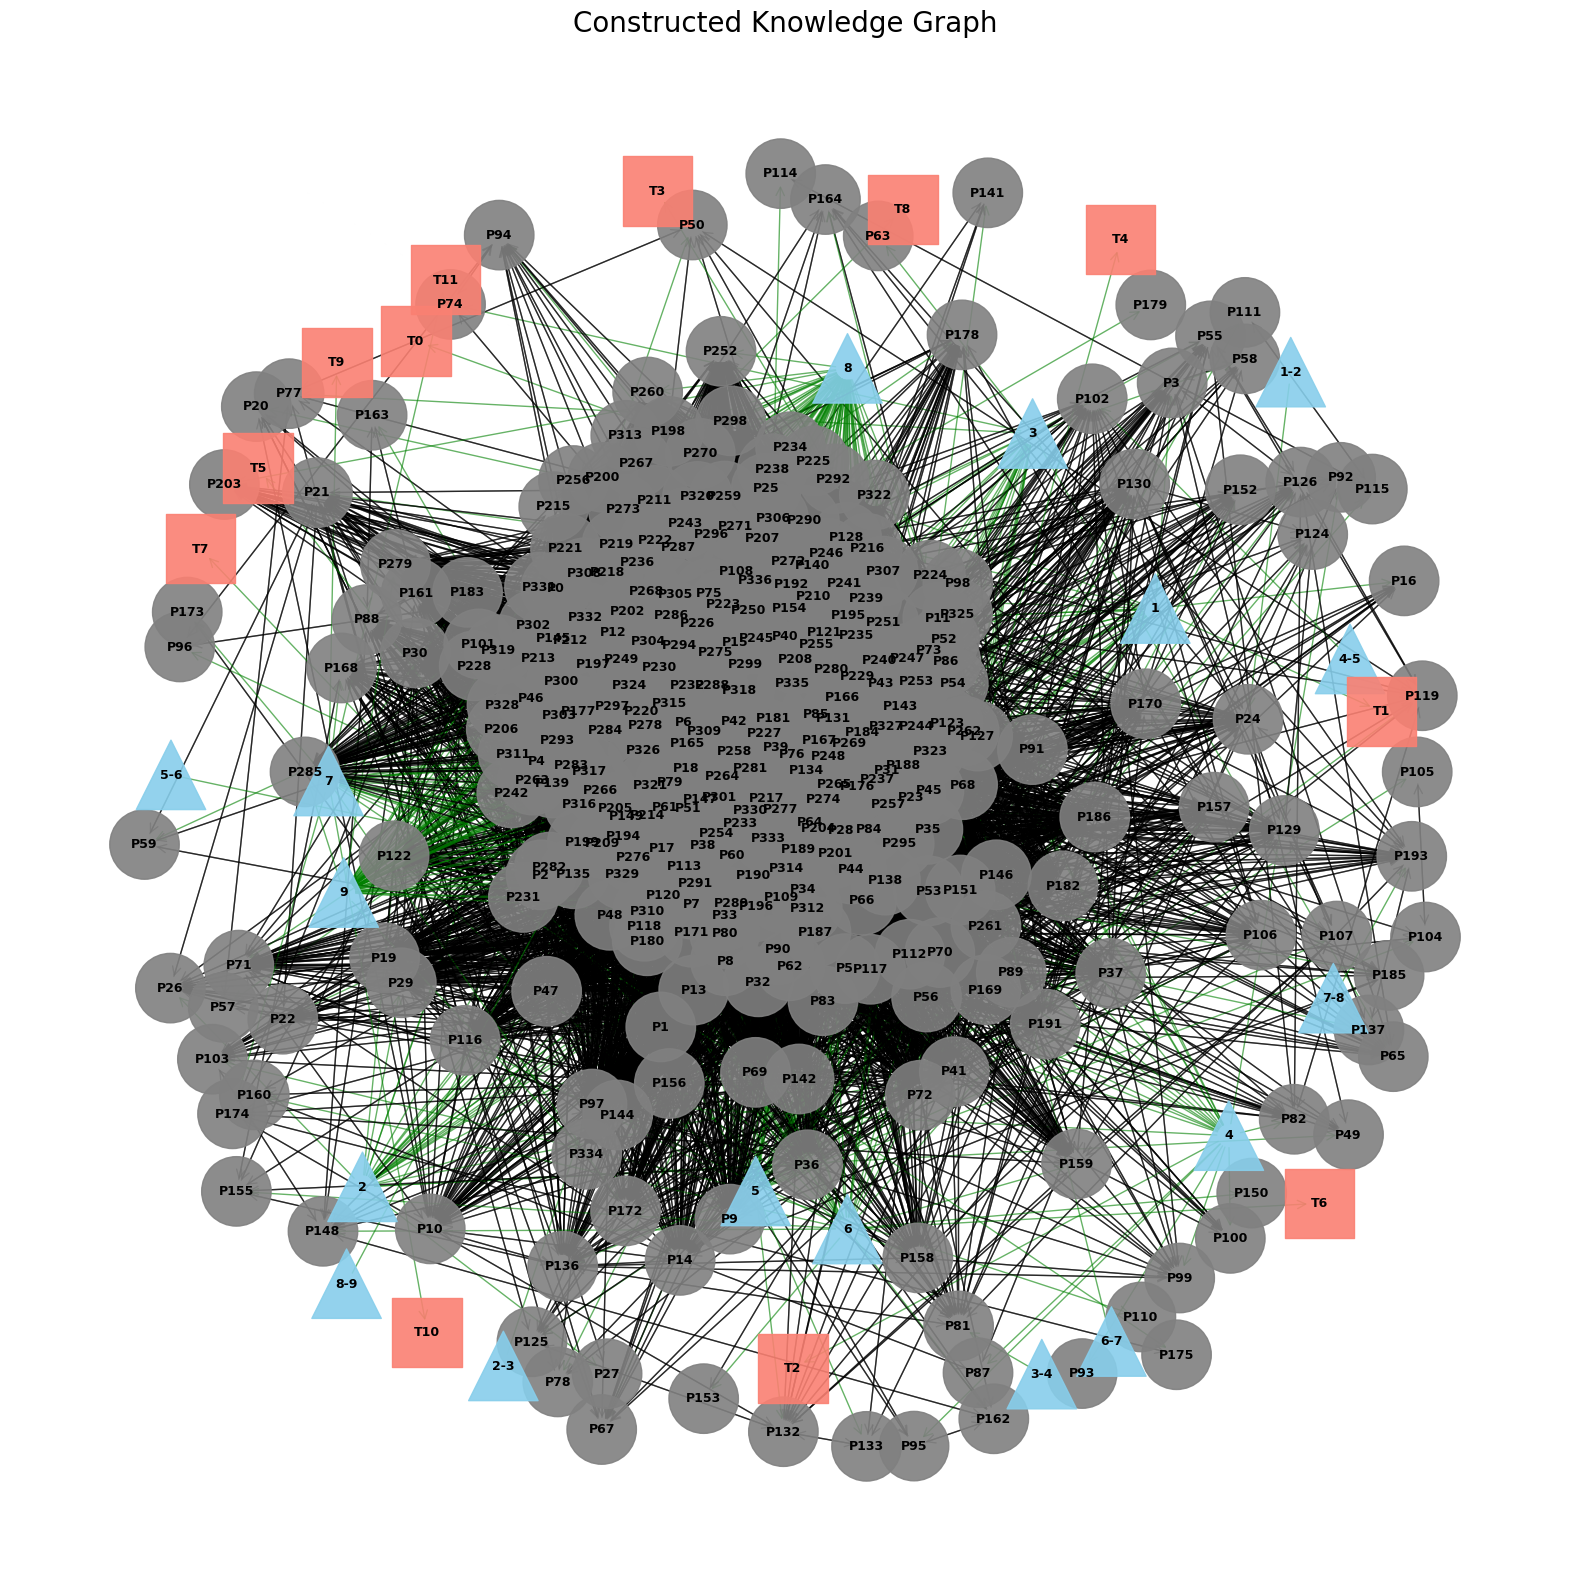

In [ ]:
visualize_graph(KG)

In [ ]:
# Load KG
import pickle

# with open("/content/graph.pkl", "rb") as f:
#     KG = pickle.load(f)

In [ ]:
def main(question, KG, top_k, context_budget):
    seed_nodes = find_seed(question, KG, embedding_model, top_k=top_k)

    retrieved_node_ids = graph_traversal(
        G=KG,
        question=question,
        seed_nodes=seed_nodes,
        llm_generate_next_passage=llm_generate_next_passage,
        context_budget=context_budget
    )

    print("Retrieved passages:")
    retrieved_passages = []
    for nid in retrieved_node_ids:
        passage = KG.nodes[nid]['content']
        print("-", passage)
        retrieved_passages.append(passage)

    # write final prompt to get the answer
    final_prompt = f"Question: {question}\n"
    final_prompt += "Based on the following context, please provide a direct answer:\n"
    final_prompt += "Context:\n" + "\n".join([f"- {p}" for p in retrieved_passages])
    final_prompt += "\nAnswer:"

    print("\n🟢 Final Answer (streaming):", end=' ', flush=True)
    final_answer = llm(final_prompt, stream=True, display_stream=True, temperature=0.3)
    print()
    return final_answer

question = "In the paper Knowledge Graph Prompting for Multi-Document Question Answering, what does the V symbol mean in Algorithm 1?"
answer = main(question, KG, top_k=1, context_budget=3)

Top 1 seed nodes found:
  - ID: Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_125 (Similarity Score: 0.7846)
--- Starting Graph Traversal ---
Initial seeds: ['Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_125']

➡️ Step 1: Visiting Node → Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_125
   Content: "Knowledge Graph Prompting for Multi-Document Question Answering. 7V′
i=Graph Traversal( {q} ∪ P i,Ci..."

   📜 Context prompt is being built with following passages:
      1. "Knowledge Graph Prompting for Multi-Document Question Answering. 7V′
i=Graph Tra..."
   🤖 LLM-Generated Next Evidence: "In the given paper, the V symbol in Algorithm 1 represents a set of nodes in the knowledge graph."


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  ↳ Adding to queue: Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_102 (score: 0.7073)
➡️ Step 2: Visiting Node → Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_102
   Content: "Knowledge Graph Prompting for Multi-Document Question Answering. Given a question qasking about the..."

   📜 Context prompt is being built with following passages:
      1. "Knowledge Graph Prompting for Multi-Document Question Answering. 7V′
i=Graph Tra..."
      2. "Knowledge Graph Prompting for Multi-Document Question Answering. Given a questio..."
   🤖 LLM-Generated Next Evidence: "In Algorithm 1 of the paper Knowledge Graph Prompting for Multi-Document Question Answering, the symbol V refers to a set of nodes or retrieved passages in the knowledge graph."


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  ↳ Adding to queue: Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_112 (score: 0.8035)
➡️ Step 3: Visiting Node → Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_112
   Content: "Knowledge Graph Prompting for Multi-Document Question Answering. Subsequently, we prefix the current..."

Traversal complete. Retrieved nodes: ['Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_125', 'Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_102', 'Knowledge Graph Prompting for Multi-Document Question Answering.pdf_passage_112']
Retrieved passages:
- Knowledge Graph Prompting for Multi-Document Question Answering. 7V′
i=Graph Traversal( {q} ∪ P i,Ci, k)by Eq (1)
8 forv∈ V′
ido
9 P.enqueue( Pi∪ {v}),C.enqueue( Nv)
10 k←k+ 1
11 ifk > K then
12 Terminate
13return Retrieved Passage Queue P
to classify whether the question is asking about the docu-
ment structure or content.
- Knowledge Graph Prom